In [44]:
import os,re
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from itertools import product
from datetime import datetime

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.linear_model import LinearRegression

import geopandas
from adjustText import adjust_text

import plot_crime as pc

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %load_ext genai

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import openai

In [3]:
plt.rcParams.update({'font.size': 8,'font.sans-serif':'Arial'})

In [39]:
base_dir = 'C:\\Users\\BatLab\\Documents\\chicago_crime'

[autoreload of plot_crime failed: Traceback (most recent call last):
  File "C:\Users\BatLab\mambaforge\envs\chicago_crime\lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\BatLab\mambaforge\envs\chicago_crime\lib\site-packages\IPython\extensions\autoreload.py", line 471, in superreload
    module = reload(module)
  File "C:\Users\BatLab\mambaforge\envs\chicago_crime\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\BatLab\Documents\chicago_crime\plot_crime.py", line 55
    def get_crime_by_year_df(r

In [47]:
return_raw = False
community_areas, demographics, nibrs_codes, iucr_codes, population, _ = pc.init_crime_data(return_raw)

In [6]:
current_year = datetime.now().year
year_lims = [2002,current_year+1]
drop_years=[2001,2002]
data_pull_date = pd.to_datetime(data.query('Year == @current_year').Date).max()#pd.to_datetime('2023-08-29')


C:\Users\BatLab\AppData\Local\Temp\ipykernel_4336\3222320070.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_pull_date = pd.to_datetime(data.query('Year == @current_year').Date).max()#pd.to_datetime('2023-08-29')


In [15]:
crime_by_year_dfs = pc.get_crime_by_year_df(raw_data)

In [17]:
n_by_type = data['Primary Type'].value_counts()
n_by_fbi_type = data['FBI_type'].value_counts()

In [18]:
crime_categories = nibrs_codes.category.unique()
fbi_crime_types = nibrs_codes.description.unique()
cca_regions = community_areas.Region.unique()

In [20]:
df_demo_commArea = pc.get_commArea_demos(demographics,community_areas)

In [22]:
r2 = {}
n = {}
df_inc = {}
eps = 1e-6
use_logx = True
use_logy = True
ind_var = 'percvac'

for ctype in used_fbi_types:
    d = crime_by_year_dfs[('FBI_type','Community Area')][ctype]
    d = d.drop(0.0,axis=1,errors='ignore')
    p = interp1d(population.columns,population.loc[d.columns,:],fill_value='extrapolate')(d.index).T
    d = (d/p).iloc[-5:,:].mean(axis=0)
    d.index = d.index.map(community_areas.Name)
    n[ctype] = d.copy()
    
    lm = LinearRegression()
    df_inc[ctype] = pd.concat([df_demo_commArea[ind_var],d.rename(ctype)],axis=1)
    df_inc[ctype][f'log_{ctype}'] = np.log10(df_inc[ctype][ctype]).replace([np.inf, -np.inf], np.nan)
    df_inc[ctype][f'log_{ind_var}'] = np.log10(df_inc[ctype][ind_var]).replace([np.inf, -np.inf], np.nan)
    
    used_dep_var = {True:f'log_{ctype}',False:ctype}[use_logy]
    used_ind_var = {True:f'log_{ind_var}',False:ind_var}[use_logx]
    
    df_lm = df_inc[ctype][[used_ind_var,used_dep_var]].dropna()
    _ = lm.fit(df_lm[[used_ind_var]],df_lm[used_dep_var])
    r2[ctype] = lm.score(df_lm[[used_ind_var]],df_lm[used_dep_var])


C:\Users\BatLab\mambaforge\envs\chicago_crime\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
demo_tmp = demographics.copy().select_dtypes(include='number')
demo_tmp.index = demo_tmp.index.map(community_areas.Name)
# demo_tmp = demo_tmp.filter(regex='pct|PCT|cap|CAP|perc|PERC')
demo_r = {}

for ctype in used_fbi_types:
    d = (
        crime_by_year_dfs[('FBI_type','Community Area')][ctype]
        .drop(0.0,axis=1,errors='ignore')
        .drop(drop_years)
    )

    p = interp1d(
        population.columns,
        population.loc[d.columns,:],
        fill_value='extrapolate'
    )(d.index).T

    d = (d/p).iloc[-5:,:].mean(axis=0)
    d.index = d.index.map(community_areas.Name)
    demo_r[ctype] = demo_tmp.corrwith(d).dropna()

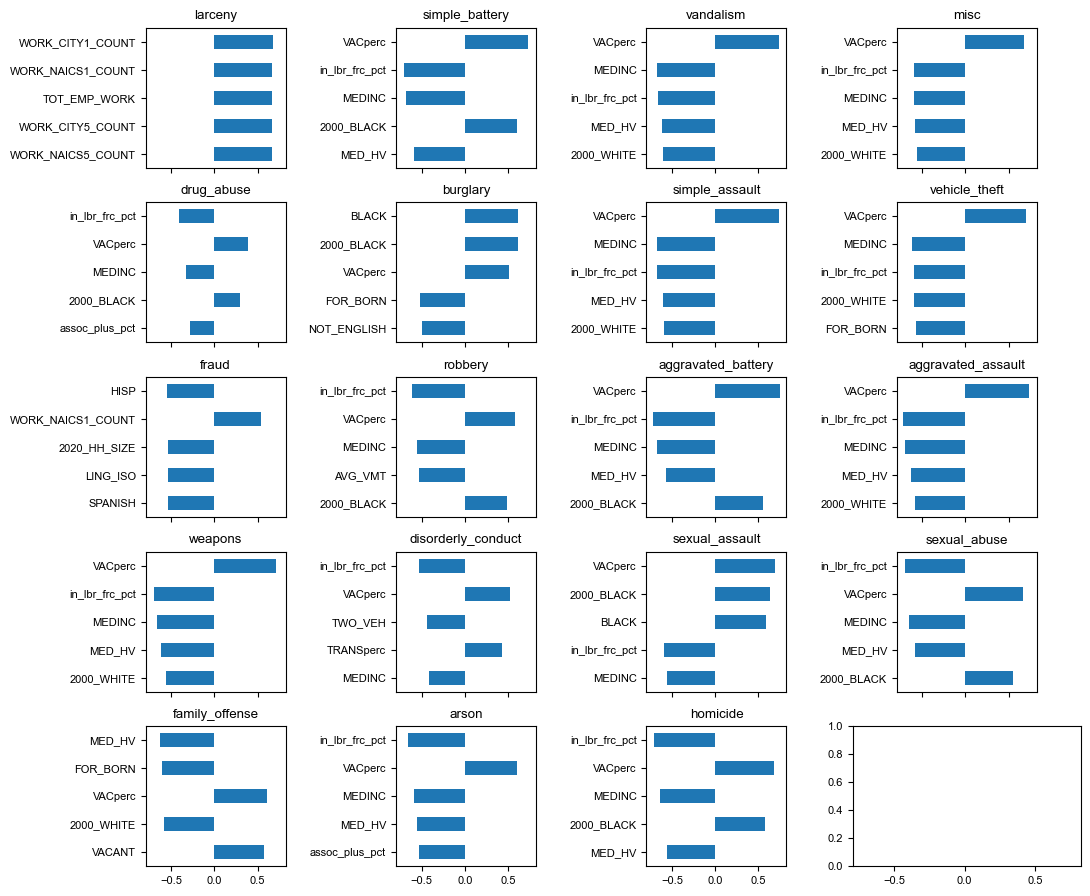

In [24]:
fig,axes = plt.subplots(5,4,figsize=(11,9),layout='tight',sharex=True)
axes=axes.flatten()
idx = {}
for ctype,ax in zip(demo_r,axes):
    idx[ctype] = demo_r[ctype].abs().sort_values().tail(5).index.values
    demo_r[ctype][idx[ctype]].plot.barh(ax=ax)
    ax.set_title(f'{ctype}')
    ax.set_box_aspect(1)

In [25]:
pd.DataFrame(idx).unstack().value_counts()

VACperc              17
MEDINC               15
in_lbr_frc_pct       15
MED_HV               11
2000_BLACK            8
2000_WHITE            7
FOR_BORN              3
assoc_plus_pct        2
WORK_NAICS1_COUNT     2
BLACK                 2
LING_ISO              1
TWO_VEH               1
TRANSperc             1
AVG_VMT               1
HISP                  1
2020_HH_SIZE          1
WORK_NAICS5_COUNT     1
SPANISH               1
NOT_ENGLISH           1
WORK_CITY5_COUNT      1
WORK_CITY1_COUNT      1
TOT_EMP_WORK          1
VACANT                1
Name: count, dtype: int64

In [26]:
pd.to_pickle(crime_by_year_dfs,'crime_by_year_dfs.pkl')

In [27]:
ctype = 'homicide'
used_dep_var = 'log_homicide'
used_ind_var = 'log_percvac'
lm = LinearRegression()

y = df_inc[ctype][used_dep_var].values.reshape(-1, 1)
X = df_inc[ctype][used_ind_var].values.reshape(-1, 1)

_=lm.fit(X,y)
lm.score(X,y)

ValueError: Input y contains NaN.

<AxesSubplot: ylabel='Frequency'>

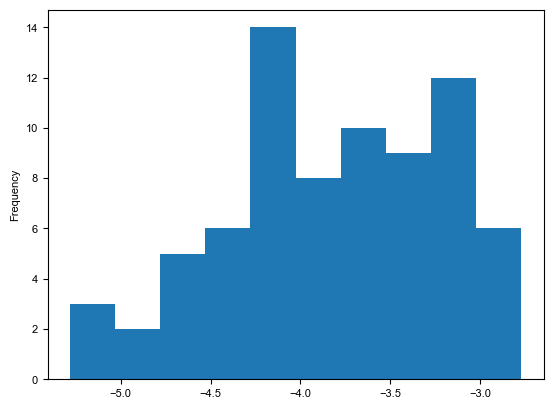

In [28]:
df_inc[ctype]['log_homicide'].plot.hist()

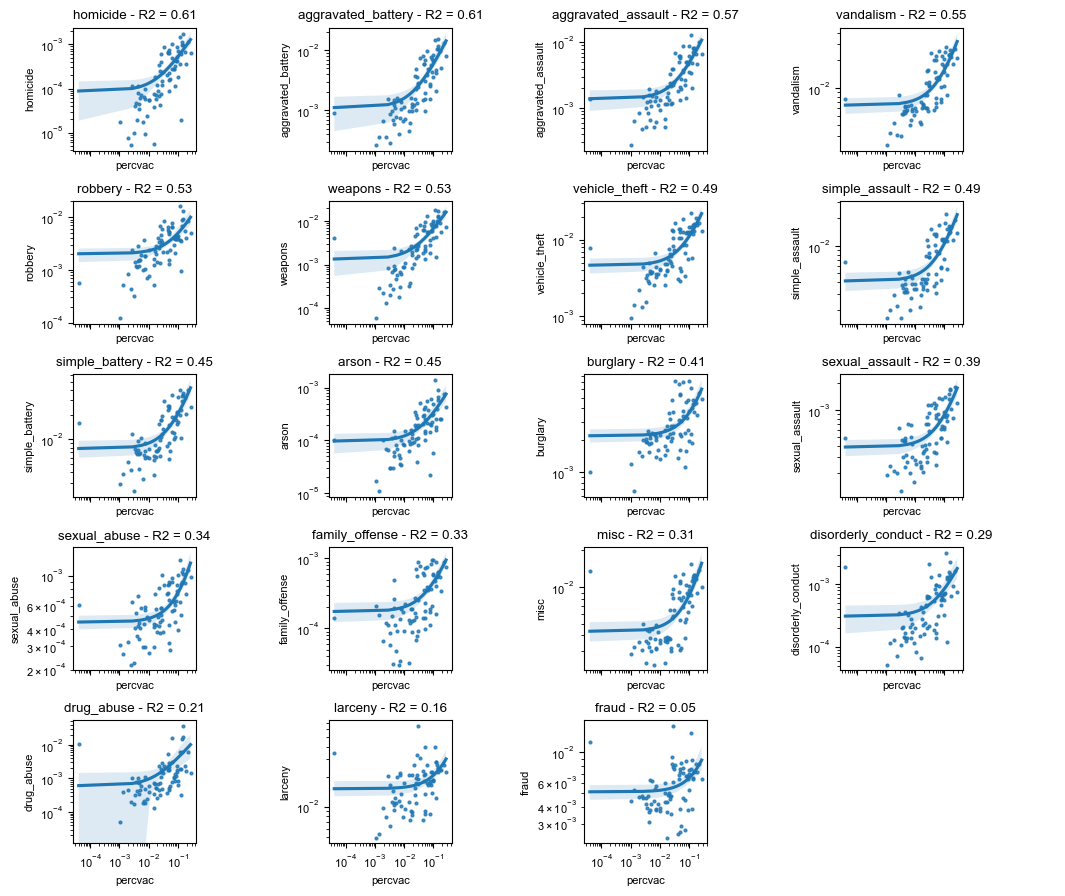

In [29]:
fig,axes = plt.subplots(5,4,figsize=(11,9),layout='tight',sharex=True)
axes=axes.flatten()
for ctype,ax in zip(pd.Series(r2).sort_values(ascending=False).index,axes):

    sns.regplot(df_inc[ctype],x=ind_var,y=ctype,ax=ax,scatter_kws={'s':4})

    ax.set_title(f'{ctype} - R2 = {r2[ctype]:.2f}')
    ax.set_box_aspect(1)
    if use_logy:
        ax.set_yscale('log')
    if use_logx:
        ax.set_xscale('log')
_=axes[-1].axis('off')

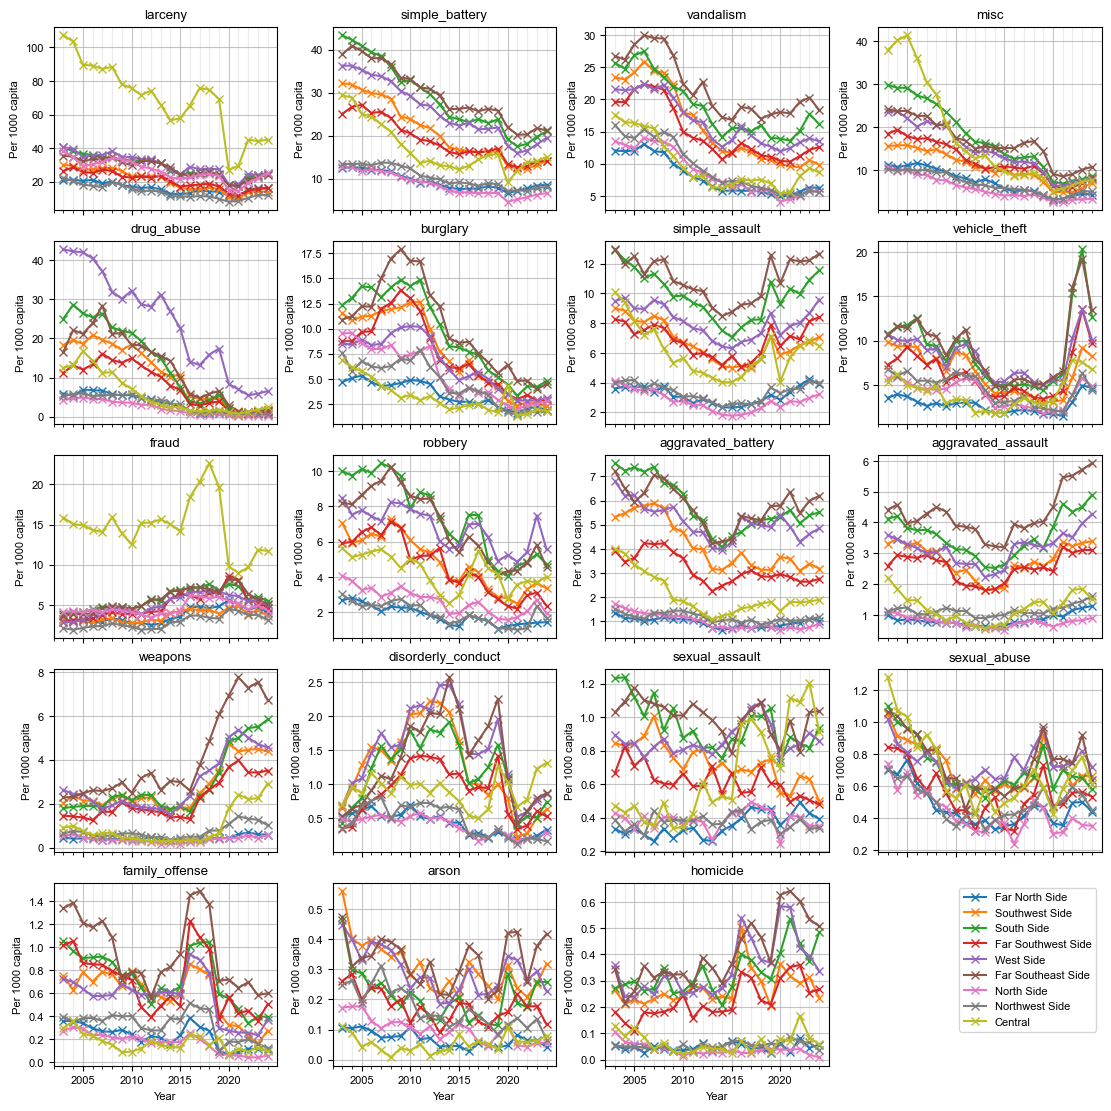

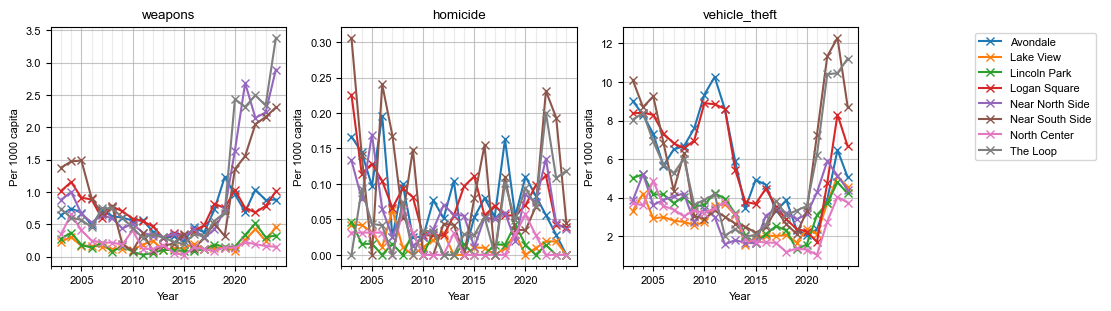

In [33]:
crime_type = 'FBI_type'
place_type = 'Community Area'
select_crimes = 'vehicle_theft'

select_places = community_areas.query('Region.isin(["North Side","Central"])').index.to_list()
select_crimes = ['weapons','homicide','vehicle_theft']

_ = plot_crime_by_type_and_place(crime_by_year_dfs,crime_type,place_type,select_places=select_places,select_crimes=select_crimes)

In [ ]:
# vehicle_theft_iucr = data.query('FBI_type == "vehicle_theft"').IUCR.value_counts()

# vehicle_theft_descr = data.query('FBI_type == "vehicle_theft"').Description.value_counts()

# vehicle_theft_iucr.index = [c.lstrip('0') if c.isnumeric() else c for c in vehicle_theft_iucr.index]

In [ ]:
# pd.concat([larceny_iucr.rename('count'),iucr_codes.loc[larceny_iucr.index,'SECONDARY DESCRIPTION']],axis=1).iloc[:5,:]

In [ ]:
select_crime_lists = {
    'weap_and_homo':['homicide','weapons'],
    'stealing':['larceny', 'burglary', 'robbery','vehicle_theft'],
    'assault_and_battery':['simple_battery','simple_assault','aggravated_battery', 'aggravated_assault','sexual_assault'],
    'society':['vandalism', 'misc', 'drug_abuse', 'fraud','sexual_abuse', 'disorderly_conduct']
}
crime_type = 'FBI_type'

for select_crime_type in select_crime_lists:
    fig = plot_regional_crime(crime_type,select_crimes=select_crime_lists[select_crime_type])
    fig.savefig(f'chicago_crime_regional_{select_crime_type}.png')

In [ ]:
import geodatasets
import geoplot

In [ ]:
map_path_name = os.path.join(
    'C:\\','Users','BatLab','Documents','chicago_crime',
    'chicago_maps','geo_export_b2278e4c-d78c-4246-aa83-acecd85cc43b.shp'
)

df = geopandas.read_file(map_path_name )
df = df.rename({'area_num_1':'Community Area'},axis=1)
df['Community Area'] = df['Community Area'].astype(int)
df = df.set_index('Community Area')
df = geopandas.GeoDataFrame(df,geometry=df.geometry)

In [ ]:
df_tmp = df[['area_numbe','community']].copy()
df_tmp.columns = ['CCAID','Name']
df_tmp.CCAID = df_tmp.CCAID.astype(int)
df_tmp.Name = df_tmp.Name.apply(lambda s: s.title())
df_tmp = df_tmp.set_index('CCAID').sort_index()

In [ ]:
data_sub = data.query('FBI_type == "homicide" and Year > 2010').reset_index()
gdf = geopandas.GeoDataFrame(
    data_sub, 
    geometry=geopandas.GeoSeries.from_xy(data_sub.Longitude, data_sub.Latitude,crs='EPSG:3857')
)
gdf = gdf.loc[~gdf.geometry.is_empty,:]

In [ ]:
import cartopy.crs as ccrs
# import matplotlib.pyplot as plt

In [ ]:
# ax = geoplot.polyplot(df, projection=geoplot.crs.AlbersEqualArea())
# geoplot.pointplot(gdf,ax=ax)
fig,ax = plt.subplots(1,1,figsize=(10,10))
df_plot = df.clip([-87.875,41.60,-87.5,42.05])
# df_plot = df.copy().clip([-87.8,41.85,-87.625,41.925])
df_plot.plot(color='white', edgecolor='black',ax=ax)

gdf.plot(
    alpha=0.1,
    marker='.',
    # markersize=1,
    # kind = 'scatter',
    ax=ax
)
geoplot.polyplot(df_plot, ax=ax, zorder=1)

texts = []
for i, row in df_plot.iterrows():
    texts.append(ax.annotate(text=row['community'], xy=row.geometry.centroid.coords[0], ha='center',color='r',fontsize=8))

# df_plot.apply(lambda x: , axis=1);

adjust_text(texts)

In [ ]:
win_size = 1
start_year = 2018
end_year = 2024
yr_ranges = [(yr,yr+win_size) for yr in range(start_year,end_year,win_size)]


In [ ]:
yr_ranges

In [ ]:
gdf = crime_by_year_dfs[('FBI_type','Community Area')].copy()
ctype = 'homicide'

d = gdf[ctype].copy()
d = d.drop(0.0,axis=1,errors='ignore')
p = interp1d(population.columns,population.loc[d.columns,:],fill_value='extrapolate')(d.index).T

p = pd.DataFrame(
    p,
    index = d.index,
    columns = d.columns.astype(int)
)

In [ ]:
cmap = 'PuRd'
used_ctypes = ['homicide']
n_ctypes = len(used_ctypes)
fig,ax_list = plt.subplots(
    n_ctypes,
    len(yr_ranges),
    figsize=(16,3*n_ctypes),
    sharex=True,
    sharey=True,
    layout='tight',
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for ctype,vmax,axes in zip(used_ctypes,[0.15,0.2,0.15],[ax_list]):
    for yrs,ax in zip(yr_ranges,axes):
        ctype_per_cap = (
            gdf
            .loc[range(yrs[0],yrs[1]),ctype]
            .mean(axis=0)
        )

        ctype_per_cap = (
            ctype_per_cap
            /(p.loc[range(yrs[0],yrs[1])].mean(axis=0))
        ).rename(ctype)
        
        ctype_per_cap = df_plot.join(ctype_per_cap).sort_values(by=ctype)
        
        ctype_per_cap.plot(
            ctype,
            vmin=0,
            vmax=0.75*(gdf[ctype]/p).unstack().max(),#vmax
            ax=ax,
            cmap=cmap
        )
        
        geoplot.polyplot(df_plot, ax=ax, zorder=1)
        
        texts = []
        for i, row in ctype_per_cap.iloc[-5:,:].iterrows():
            texts.append(
                ax.annotate(
                    text=row['community'],
                    xy=row.geometry.centroid.coords[0],
                    ha='center',
                    color='b',
                    fontsize=8
                )
            )
            
        ax.set_axis_off()
        ax.set_title(f'{ctype}: {yrs[0]} - {yrs[1]-1}')
        adjust_text(texts,ax=ax,arrowprops=dict(arrowstyle='->', color='red'),force_text=(0.1,0.5))

In [ ]:
clip_bounds = [-87.875,41.60,-87.5,42.05]
df_plot = df.clip(clip_bounds)
ctypes = ['homicide','weapons','vehicle_theft']
total_pop = p.sum(axis=1)

fig,axes_list = plt.subplots(
    len(ctypes),
    len(yr_ranges),
    figsize=(16,16),
    sharex=True,
    sharey=True,
    layout='tight',
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for ctype, axes in zip(ctypes,axes_list):
    yr1,yr2 = yr_ranges[0][0],yr_ranges[-1][1]
    data_sub_ctype = data.query('Year >= @yr1  and Year < @yr2 and FBI_type == @ctype')
    n_total_ctypes = data_sub_ctype.shape[0]
    all_heatmaps = []
    all_ims = []
    for yrs,ax in zip(yr_ranges,axes):
        yr1,yr2 = yrs
        data_sub = data_sub_ctype.query('Year >= @yr1  and Year < @yr2').reset_index()
        gdf = geopandas.GeoDataFrame(
            data_sub, 
            geometry=geopandas.GeoSeries.from_xy(data_sub.Longitude, data_sub.Latitude,crs='EPSG:3857')
        )
        gdf = (
            gdf
            .loc[~gdf.geometry.is_empty,:]
            .clip(clip_bounds)
        )

        avg_pop = total_pop[range(*yrs)].mean()
        scale = 1e6/avg_pop
        # max_n_year = data_sub_ctype.Year.value_counts().max()
        vrange = (0,n_total_ctypes/50e3)
        hm,im = heatmap(
            gdf,
            ax=ax,
            bins=(100,100),
            smoothing=1.5,
            cmap_str='PuRd',
            use_colorbar = False,
            density = False,
            vrange = (None,None),
            scale=scale,
            cmap_thresh=0.01
        )
        all_heatmaps.append(hm)
        all_ims.append(im)
        
        geoplot.polyplot(df_plot, ax=ax, zorder=1)
        ax.set_title(f'{ctype}: {yrs[0]} - {yrs[1]-1}')
    # vmax = np.nanmax(np.vstack(all_heatmaps))
    # vmin = np.nanmin(np.vstack(all_heatmaps))
    vmin, vmax = np.nanquantile(np.vstack(all_heatmaps),[0.1,0.99])
    for im in all_ims:
        _ = im.set(clim=(vmin,vmax))

In [ ]:
vmin

In [ ]:
ax = geoplot.quadtree(
    gdf.assign(count=1), linewidth=1,
    projection=geoplot.crs.AlbersEqualArea(),
    clip=df_plot.simplify(0.001), nmax=5
)

In [ ]:

ax = geoplot.quadtree(
    gdf.assign(count=1),hue='count',agg=np.sum,
    cmap='Reds', edgecolor='white', linewidth=1,
    projection=geoplot.crs.AlbersEqualArea(),
    clip=df_plot.simplify(0.001), nmax=5
)
# geoplot.polyplot(
#     df_plot,
#     ax=ax,
#     linewidth=0.1,
#     alpha=0.1
# )

In [ ]:
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation

In [ ]:
cluster_fbi_types = ['larceny', 'simple_battery', 'vandalism', 'drug_abuse',
       'burglary', 'simple_assault', 'vehicle_theft', 'robbery',
       'aggravated_battery', 'aggravated_assault', 'weapons',
       'disorderly_conduct', 'sexual_assault', 'sexual_abuse',
       'family_offense', 'homicide']

In [ ]:
n_clust = 3
km = KMeans(n_clusters = n_clust)
ms = MeanShift(bandwidth=2.5)
ap = AffinityPropagation(damping=0.5)

In [ ]:
data_df = crime_by_year_dfs[(crime_type,place_type)].copy().drop([2001,2002])
data_df =(data_df/data_df.max())
data_df = data_df.T.unstack(1).loc[cluster_fbi_types]

In [ ]:
idx_km = km.fit_predict(data_df)
idx_ms = ms.fit_predict(data_df)
idx_ap = ap.fit_predict(data_df)

In [ ]:
[data_df.index[[i == k for i in idx_km]].to_list() for k in range(7)]

In [ ]:
crime_type = 'FBI_type'
for k in range(n_clust):
    select_crimes = data_df.index[[i == k for i in idx_km]].to_list()
    plot_regional_crime(crime_type,select_crimes=select_crimes)
    

In [ ]:
data.columns

In [ ]:
data_df = data.loc[data.Year > 2018,:]

In [ ]:
data_df.query('FBI_type == "vehicle_theft"').IUCR.value_counts()

In [ ]:
data_df.query('FBI_type == "vehicle_theft"')['Location Description'].value_counts()[:20]

In [ ]:
dtimes = [datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p') for d in data_df.query('FBI_type == "vehicle_theft"')['Date']]

In [ ]:
plt.hist([d.hour for d in dtimes])

In [ ]:
data_df.query('FBI_type == "vehicle_theft"')['Community Area'].plot.hist()

In [ ]:
data.columns

In [ ]:
ctype = 'CRIM SEXUAL ASSAULT'
d = year_by_type_region[ctype][select_region].drop(drop_years)
p = interp1d(population.columns,population.loc[select_region,:],fill_value='extrapolate')(d.index).T
d

In [ ]:
year_by_type_region[ctype]

In [ ]:
fig,axes = plt.subplots(9,3,sharex=True,layout='constrained',figsize=(8,12),sharey=False)
# axes = axes.flatten()

for reg_ax,reg in zip(axes,cca_regions):
    for ax,cat in zip(reg_ax,crime_categories):
        d = year_by_category_region[cat][[reg]].sum(axis=1).drop(drop_years)
        f = interp1d(population.columns,population.loc[reg,:],fill_value='extrapolate')
        d = d/f(d.index)
        d.plot(style='-x',ax=ax,grid=True)
        ax.set_title(f'{reg} - {cat}')

In [ ]:
d = year_by_category_region[cat][[reg]].sum(axis=1).drop(drop_years)

In [ ]:
reg